<code>create_SIE_damped_anomaly_benchmark.ipynb</code>.  This notebook creates a damped anomaly forecast for SIE from the observed SIE.

### Load packages

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from S2S_sea_ice_preprocess import create_obs_climatology_ROLLING, create_aggregate_regions
from S2S_sea_ice_metrics import calc_damped_anomaly

### Overview

* Load observed SIE for desired obs set
* Create our custom aggregate regions
* Create an observed climatology (we typically use a 10-year rolling mean)
* Load autocorrelation coefficients
* Calculate damped anomaly

#### Calculating the damped anomaly

The damped anomaly is defined using the climatological trend, calculated above, and then adding a damped anomaly. Following Wayand et al. (2019):

$$SIE_{damped}(doy_I,doy_V) = SIE_{clim}(doy_V) + D(doy_i,doy_v)$$ 

where $doy_I$ and $doy_V$ are the initial and valid days of the year, respectively.  $D$, the damped anomaly, is modeled baesd on a first-order autoregressive (AR-1) process:

$$D(doy_I,doy_V) = [SIE_{obs}(doy_I) - SIE_{clim}(doy_I)]\alpha (doy_I,doy_V)$$

$SIE_O$ is the most recent observation available on $doy_I$.  $\alpha$ is the correlation between SIE at each combination of $I$ and $V$ from our observations.  Calculating $\alpha$ for every combination is expensive, so we'll follow Wayand et al. (2019)'s Equation 3 and approximate $\alpha$ based on a one-week lagged autocorrelation: 

$$\alpha(doy_I,doy_V) \approx \left< SIE_{obs}(doy_I), SIE_{obs}(doy_I + 7) \right>^{n/7} $$

$n$ is the lead time in days

<b>inputs:</b><br>
<li>  <code>obs_name</code>: (NSIDC_0079, NSIDC_0051, OSISAF) [observational product we are using as our "truth"]</li>
<li>  <code>n_years</code>: [number of years over which to calculate the rolling mean] (default is 10)

In [2]:
obs_name = 'NSIDC_0079'
n_years = 10

Load observations

In [3]:
if obs_name == 'NSIDC_0079':
    obs_type = 'sipn_nc_yearly_agg_commonland'
elif obs_name == 'NSIDC_0051':
    obs_type = 'sipn_nc_yearly_agg'
    
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc')#,combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11627)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2020-10-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Get aggregate regions and convert to Pandas dataframe

In [4]:
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})
if obs_name == 'OSISAF':
    obs_SIE['valid date'] = pd.to_datetime(obs_SIE['valid date']).dt.date

Calculate observed climatology from <code>n_year</code> rolling mean

observed climatology created


Text(0.5, 1.0, 'Observed Climatology')

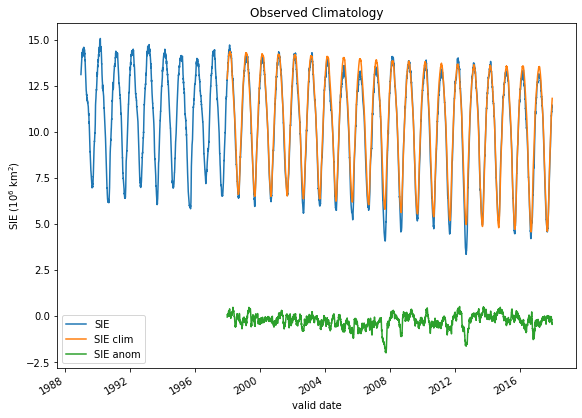

In [5]:
last_year = 2017 # last year included in estimations of alpha
# trim obs to get rid of years not used to calculate alpha
obs_SIE = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.year.isin(np.arange(1979,last_year+1))]
obs_SIE = create_obs_climatology_ROLLING(obs_SIE,n_years)
print('observed climatology created')
#
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1.2,1.2])
obs_SIE.where(obs_SIE['region']=='panArctic').plot(x='valid date',y=['SIE','SIE clim','SIE anom'],ax=ax1)
ax1.set_ylabel('SIE (10$^6$ km$^2$)')
ax1.set_title('Observed Climatology')

Drop leap days

In [7]:
obs_SIE = obs_SIE.where(obs_SIE['valid day of year']!='02-29').dropna(how='all')

now we load the $\alpha$ coefficients from Nic's files.  We'll do a bit of adjusting to change the coordinates (e.g., convert the DoY to date of year) so it matches the SIE data better.  We can also quickly plot the alpha coefficients to look at how persistence varies throughout the year (spring predictability barrier is very obvious)

Text(0.5, 1.0, 'alpha for panArctic, fore time: 25')

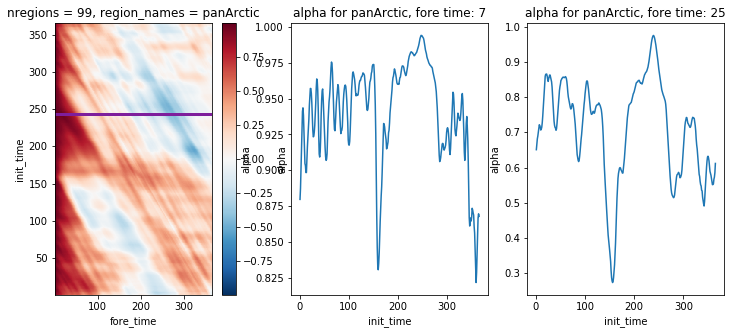

In [8]:
alpha_filepath = '/home/disk/sipn/nicway/data/obs/NSIDC_0079/alpha_agg/1990_2017_Alpha.nc'
alphas = xr.open_dataset(alpha_filepath)
fig2,(ax2,ax2b,ax2c) = plt.subplots(1,3,figsize=(12,5))
alphas.alpha.sel(nregions=99).plot(ax=ax2)
days_of_yr = pd.DataFrame(data={'valid day of year':pd.to_datetime(obs_SIE['valid date']).dt.strftime('%m-%d').unique()})
days_of_yr['doy'] = np.arange(1,366)
days_of_yr = days_of_yr.set_index('doy')
# Line marks September 1
ax2.axhline(y=244,color='xkcd:purple',linewidth=3)
alphas.sel(fore_time=7,nregions=99).alpha.plot(ax=ax2b)
ax2b.set_title('alpha for panArctic, fore time: 7')
#
alphas.sel(fore_time=25,nregions=99).alpha.plot(ax=ax2c)
ax2c.set_title('alpha for panArctic, fore time: 25')

Save regions as a text file in case we ever need it

In [9]:
regions_list = pd.DataFrame(columns=['nregions','region_names'])
regions_list['nregions'] = alphas.nregions
regions_list['region_names'] = alphas.region_names
regions_list.set_index('nregions')
save_regions = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/REGIONS_LIST.csv'
regions_list.to_csv(save_regions)

Create the damped anomaly.  We use the $\alpha$ coefficients that we just loaded and we multiply the anomalous SIE by the alpha (damped anomaly), and add that back to the climatological SIE. 
Da: damped anomaly
D_SIE: SIE forecast using damped anomaly

In [13]:
max_fore = 21
SIE_damped = pd.DataFrame(columns=['init date','valid date','lead time','SIE','SIE anom','SIE clim','region'])

#for i_reg in np.arange(0,len(regions_list)):
i_reg = 9
ireg_name = regions_list['region_names'].iloc[i_reg]
print('running ',ireg_name)
reg_num = regions_list['nregions'].iloc[i_reg]
obs_test = obs_SIE.where(obs_SIE['region']==ireg_name).dropna(how='all')
alpha_test = alphas.alpha.sel(nregions=reg_num)
#
SIE_da = calc_damped_anomaly(obs_test,alpha_test,max_fore,days_of_yr)
SIE_damped = SIE_damped.append(SIE_da)

running  Laptev Sea


In [26]:
SIE_test1 = SIE_damped.set_index(['lead time']).xs(pd.Timedelta(21,'D')).reset_index()
obs_test1 = obs_test.where(obs_test['valid date'].isin(SIE_test1['valid date']))

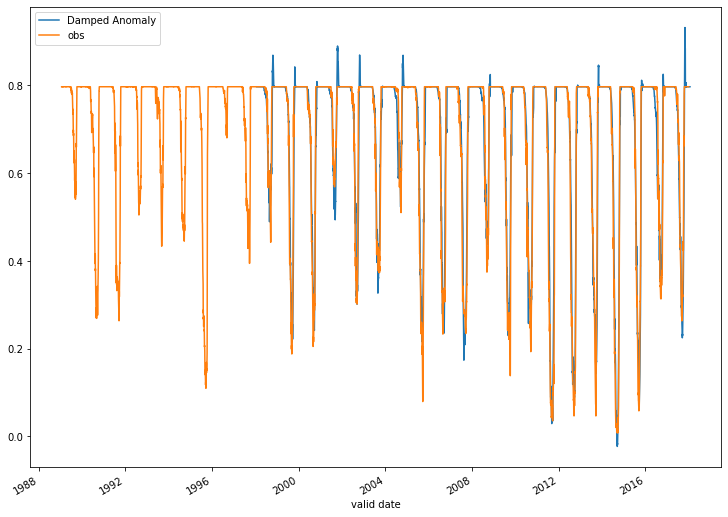

In [27]:
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1.6,1.6])
SIE_test1.plot(x='valid date',y='SIE',ax=ax1,label='Damped Anomaly')
obs_test1.plot(x='valid date',y='SIE',ax=ax1,label='obs')


Save damped anomaly forecast

In [ ]:
fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/'
fname_save = fpath_save+'OBS_{obs_name}/DAMPED_ANOMALY_FORECAST_{n_years}_rolling_mean.csv'.format(obs_name=obs_name,n_years=n_years)
SIE_damped.to_csv(fname_save)